# Logistic Regression - processing the Titanic Dataset

In this notebook, the titanic dataset will be used to  
explore the data (EDA) and preprocess it for the next notebook to fit a logistic regression classifier.

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
sns.set_style('whitegrid')

## EDA

In [67]:
# Import the dataset
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here’s the Data Dictionary, so we can understand the columns info . better:

- PassengerID: type should be integers

- Survived: survived or not

- Pclass: class of Travel of every passenger

- Name: the name of the passenger

- Sex: gender

- Age: age of passengers

- SibSp: No. of siblings/spouse aboard

- Parch: No. of parent/child aboard

- Ticket: Ticket number

- Fare: what Prices they paid

- Cabin: cabin number

- Embarked: the port in which a passenger has embarked.  
        - C: Cherbourg , S: Southhampton , Q: Queenstown

/var/folders/ls/n9stnb2d0qx6yp0w1qljy79w0000gn/T/ipykernel_10748/2622444760.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=titanic, palette='hls');


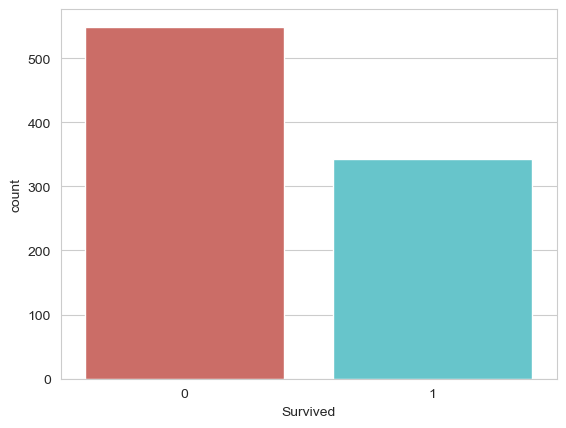

In [68]:
# Distribution of target class
sns.countplot(x='Survived', data=titanic, palette='hls');

In [69]:
# Missing values
titanic.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [70]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Ok, so there are only 891 rows in the titanic data frame. 


Cabin is almost all missing values, so we can drop that variable completely, but what about age? Age seems like a relevant predictor for survival right? We'd want to keep the variables, but it has 177 missing values. 


We are going to need to find a way to approximate for those missing values!

#### Dropping missing values: 


So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:

Survived - This variable is obviously relevant.

Pclass - Does a passenger's class on the boat affect their survivability?

Sex - Could a passenger's gender impact their survival rate?

Age - Does a person's age impact their survival rate?

SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability

Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability

Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.

Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? For now they're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [71]:
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


/var/folders/ls/n9stnb2d0qx6yp0w1qljy79w0000gn/T/ipykernel_10748/335454852.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls');


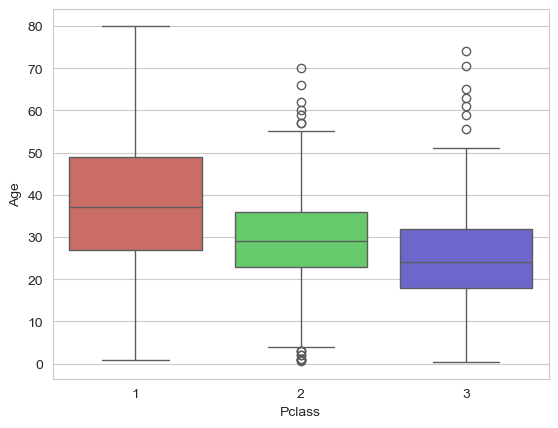

In [72]:
sns.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls');

Speaking roughly, we could say that the younger a passenger is, the more likely it is for them to be in 3rd class. The older a passenger is, the more likely it is for them to be in 1st class. So there is a loose relationship between these variables. So, let's write a function that approximates a passengers age, based on their class. From the box plot, it looks like the median age of 1st class passengers is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

So let's write a function that finds each null value in the Age variable, and for each null, checks the value of the Pclass and assigns an age value according to the average age of passengers in that class.

In [73]:
# Check for median age per class
titanic_data.groupby('Pclass').median(numeric_only=True)

,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,
1,1.0,37.0,0.0,0.0,60.2875
2,0.0,29.0,0.0,0.0,14.2500
3,0.0,24.0,0.0,0.0,8.0500


In [74]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

When we apply the function and check again for null values, we see that there are no more null values in the age variable.

In [75]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

/var/folders/ls/n9stnb2d0qx6yp0w1qljy79w0000gn/T/ipykernel_10748/3837342890.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Age = cols[0]
/var/folders/ls/n9stnb2d0qx6yp0w1qljy79w0000gn/T/ipykernel_10748/3837342890.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

There are 2 null values in the embarked variable. We can drop those 2 records without loosing too much important information from our dataset, so we will do that.

In [76]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

The next thing we need to do is reformat our variables so that they work with the model.
Specifically, we need to reformat the Sex and Embarked variables into numeric variables.

In [77]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [78]:
gender = pd.get_dummies(titanic_data['Sex'])#,drop_first=True)
#gender = pd.get_dummies(titanic_data['Sex'], drop_first=True)
gender = pd.get_dummies(titanic_data['Sex'], drop_first=True, dtype=int) #avoid collinearity (female and male same information/describe same just reversed) - don't want highly correlated columns of one feature
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [79]:
#embark_location = pd.get_dummies(titanic_data['Embarked'], drop_first=True)
embark_location = pd.get_dummies(titanic_data['Embarked'], drop_first=True, dtype=int)
embark_location.head()
# not completely highly correlated - both stay in data

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [80]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [81]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [82]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### Checking for independence between features¶

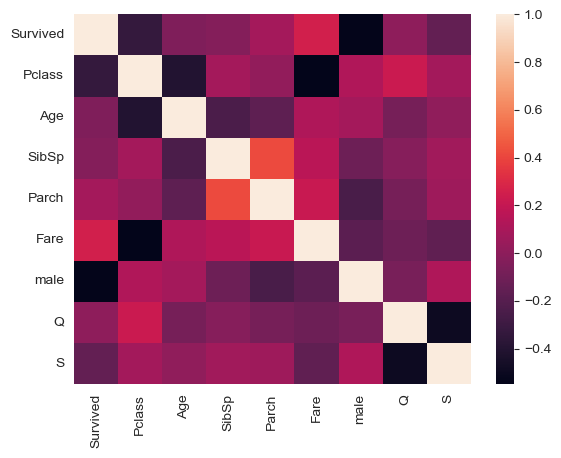

In [83]:
sns.heatmap(titanic_dmy.corr());

In [84]:
titanic_dmy.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
Survived,1.000000,-0.335549,-0.052051,-0.034040,0.083151,0.255290,-0.541585,0.004536,-0.151777
Pclass,-0.335549,1.000000,-0.405549,0.081656,0.016824,-0.548193,0.127741,0.220558,0.076466
Age,-0.052051,-0.405549,1.000000,-0.242807,-0.170089,0.120938,0.083730,-0.080875,0.013598
SibSp,-0.034040,0.081656,-0.242807,1.000000,0.414542,0.160887,-0.116348,-0.026692,0.069438
Parch,0.083151,0.016824,-0.170089,0.414542,1.000000,0.217532,-0.247508,-0.081585,0.061512
Fare,0.255290,-0.548193,0.120938,0.160887,0.217532,1.000000,-0.179958,-0.116684,-0.163758
male,-0.541585,0.127741,0.083730,-0.116348,-0.247508,-0.179958,1.000000,-0.075217,0.121405
Q,0.004536,0.220558,-0.080875,-0.026692,-0.081585,-0.116684,-0.075217,1.000000,-0.499261
S,-0.151777,0.076466,0.013598,0.069438,0.061512,-0.163758,0.121405,-0.499261,1.000000


In [85]:
# Fare and Pclass are not independent of each other, so I am going to drop one of these. 

titanic_dmy.drop(['Fare'] ,axis=1,inplace=True)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,male,Q,S
0,0,3,22.0,1,0,1,0,1
1,1,1,38.0,1,0,0,0,0
2,1,3,26.0,0,0,0,0,1
3,1,1,35.0,1,0,0,0,1
4,0,3,35.0,0,0,1,0,1


In [86]:
# We have 6 predictive features that remain. The rule of thumb is 50 records per feature... 
# so we need to have at least 300 records in this dataset. Let's check again.
# Ok, we have 889 records so we are fine.
titanic_dmy.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   male      889 non-null    int64  
 6   Q         889 non-null    int64  
 7   S         889 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 62.5 KB


In [90]:
# Split dataset
X = titanic_dmy.iloc[:,1:].values
y = titanic_dmy.iloc[:,0].values

In [ ]:
#Store the preprocessed dataframe to make it available in eg. other notebooks
%store titanic_dmy

# Or store/save dataset now in the database (but if you only want use it for testing and using it in another notebook use %store variable)

Stored 'titanic_dmy' (DataFrame)
